- Import a single stock
- Calculate Moving Average
- Calculate STD
- Check if any day's close price is more than 2 STD's lower than the MA
- If yes, mark it on a graph
- Check if it recovers from the fall


## TODOs

- Put all tickers together
- Make call for last 5 min data

In [126]:
import os
from os.path import exists
from glob import glob
import shutil
import time
from datetime import datetime
import pytz
from IPython.display import clear_output

import yfinance as yf

import pandas as pd
import numpy as np
from numpy import NaN

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from playsound import playsound

import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

my_year_month_fmt = mdates.DateFormatter('%m/%y')


In [127]:
def delete_data_dir():
    for match in glob('*data'):
       shutil.rmtree(match)

delete_data_dir()

In [128]:
# large_cap = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].values.tolist()[:5]
# mid_cap = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0]['Ticker symbol'].values.tolist()[:5]
# small_cap = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1]['Ticker symbol'].values.tolist()[:5]

In [129]:

# https://www.investopedia.com/top-energy-stocks-4582081
energy_most_momentum = ['AR', 'OXY', 'DVN', 'XLE']
energy_fast_growing = ['MRO', 'CTRA', 'COP']
energy_low_pe_0827 = ['APA', 'MRC', 'FANG']

# https://finance.yahoo.com/news/10-energy-stocks-buy-winter-230454016.html
yahoo_energy_picks = ['XOM', 'CVX', 'DVN', 'TTE', 'ENB', 'BP', 'CTRA', 'VLO', 'BP']

con_energy_tickers = list(set(
    yahoo_energy_picks + 
    energy_low_pe_0827 + 
    energy_fast_growing + 
    energy_most_momentum +
    ['RYDAF', 'EQNR', 'PBR']
))


alt_energy_eu = ['VWDRY', 'DNNGY', 'IBDRY']
# https://www.investopedia.com/investing/alternative-energy-stocks/ ++
alt_energy_others = ['JKS', 'TAC', 'DQ', 'CWEN', 'EE', 'AQN', 'ENPH', 'EVA', 'ORA', 'ICLN', 'NEE', 'BEP', 'BEPC', 'FSLR', 'SEDG', 'RUN', 'NOVA']
# https://seekingalpha.com/news/3841098-solar-clean-energy-stocks-surge-again-on-europes-planned-green-push
alt_energy_seeking_alpha = ['TAN', 'ENPH', 'SEDG', 'SHLS', 'MAXN', 'FTCI', 'SPWR', 'SOL', 'CSIQ', 'ARRY', 'JKS', 'NOVA', 'RUN', 'DQ', 'FSLR', 'BE', 'BLDP', 'GNRC', 'FCEL', 'PLUG', 'FAN', 'ICLN', 'QCLN', 'PBW', 'PBD', 'ACES', 'CNRG', 'SMOG', 'ERTH']


alt_energy_tickers = list(set(
    alt_energy_eu +
    alt_energy_others +
    alt_energy_seeking_alpha
))

# tickers = large_cap + mid_cap + small_cap
# tickers = sorted(con_energy_tickers)
all_energy_tickers = list(set(con_energy_tickers + alt_energy_tickers))

In [130]:
# Set other tickers here if you like.

tickers = sorted(all_energy_tickers)
tickers, len(tickers)

(['ACES',
  'APA',
  'AQN',
  'AR',
  'ARRY',
  'BE',
  'BEP',
  'BEPC',
  'BLDP',
  'BP',
  'CNRG',
  'COP',
  'CSIQ',
  'CTRA',
  'CVX',
  'CWEN',
  'DNNGY',
  'DQ',
  'DVN',
  'EE',
  'ENB',
  'ENPH',
  'EQNR',
  'ERTH',
  'EVA',
  'FAN',
  'FANG',
  'FCEL',
  'FSLR',
  'FTCI',
  'GNRC',
  'IBDRY',
  'ICLN',
  'JKS',
  'MAXN',
  'MRC',
  'MRO',
  'NEE',
  'NOVA',
  'ORA',
  'OXY',
  'PBD',
  'PBR',
  'PBW',
  'PLUG',
  'QCLN',
  'RUN',
  'RYDAF',
  'SEDG',
  'SHLS',
  'SMOG',
  'SOL',
  'SPWR',
  'TAC',
  'TAN',
  'TTE',
  'VLO',
  'VWDRY',
  'XLE',
  'XOM'],
 60)

In [131]:
today = time.strftime("%Y-%m-%d")
dir_path_for_todays_data = f'{today}_data'
period = '6mo'
interval = '1d'
ma_and_std_window = 20

In [132]:
def download_data(tickers, period, interval):
    return yf.download(
      tickers = tickers,
      period=period,
      interval=interval,
      group_by = 'ticker'
  )


In [133]:
def use_existing_data(dirpath_todays_data, tickers):
    '''
    Use this if dir for today's data exists.
    Read the data into a dictionary of dataframes.
    Return the dictionary.
    '''
    multi_df = {}

    for ticker in tickers:
        filepath = f"{dirpath_todays_data}/{today}_{ticker}.csv"
        
        if exists(filepath):
            df = pd.read_csv(filepath, index_col=['Date'], parse_dates=['Date'])
            multi_df[ticker] = df
            print(f"Using existing data for {ticker}.")

    return multi_df

def get_and_prep_new_stock_data(multi_df, tickers, dirpath_todays_data, today):
  '''
  Use this if dir for today's data does not exist.
  Download the data, get relevant metrics, and save it to a directory as CSV.
  '''
  new_multi_df = {}

  for ticker in tickers:
    df = multi_df[ticker][['Close']]
    df['Close Rolling Mean'] = df.Close.rolling(ma_and_std_window).mean()
    df['Close STD'] = df.Close.rolling(ma_and_std_window).std()

    df['1 STD Below Mean (Val)'] = df['Close Rolling Mean'] - df['Close STD']
    df['1 STD Below Mean (Bool)'] = df['Close'] < df['1 STD Below Mean (Val)']
    
    df['2 STD Below Mean'] = df['Close Rolling Mean'] - 2 * df['Close STD']
    df['2 STD Below Mean (Close)'] = np.where(df['Close'] < df['2 STD Below Mean'], df['Close'], NaN)
    
    df.to_csv(f"{dirpath_todays_data}/{today}_{ticker}.csv")

    new_multi_df[ticker] = df

  return new_multi_df

In [134]:
def get_todays_data(tickers, period, interval, dir_path_for_todays_data, today):
    if exists(dir_path_for_todays_data):
        print("Today's data exists. Reusing it.")
        return use_existing_data(dir_path_for_todays_data, tickers)
    else:
        print("Today's data not found in project dir. Getting new data.")
        os.mkdir(dir_path_for_todays_data)
        multi_df = download_data(tickers, period, interval)
        return get_and_prep_new_stock_data(
            multi_df, tickers, dir_path_for_todays_data, today)


multi_df = get_todays_data(tickers, period, interval, dir_path_for_todays_data, today)

Today's data not found in project dir. Getting new data.
[*********************100%***********************]  60 of 60 completed


In [135]:
# multi_df['XOM'].tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Fitted
Datetime,,,,,,,
2023-04-10 09:30:00-04:00,161.419998,162.000000,161.369995,161.767700,161.767700,2390815,160.574463
2023-04-10 09:31:00-04:00,161.769196,161.809998,161.580002,161.690002,161.690002,241318,160.577810
2023-04-10 09:32:00-04:00,161.709900,161.779999,161.559998,161.580093,161.580093,288138,160.581158
2023-04-10 09:33:00-04:00,161.589905,161.860001,161.380005,161.589905,161.589905,324481,160.584506
2023-04-10 09:34:00-04:00,161.580002,161.779999,161.380005,161.529999,161.529999,274833,160.587853


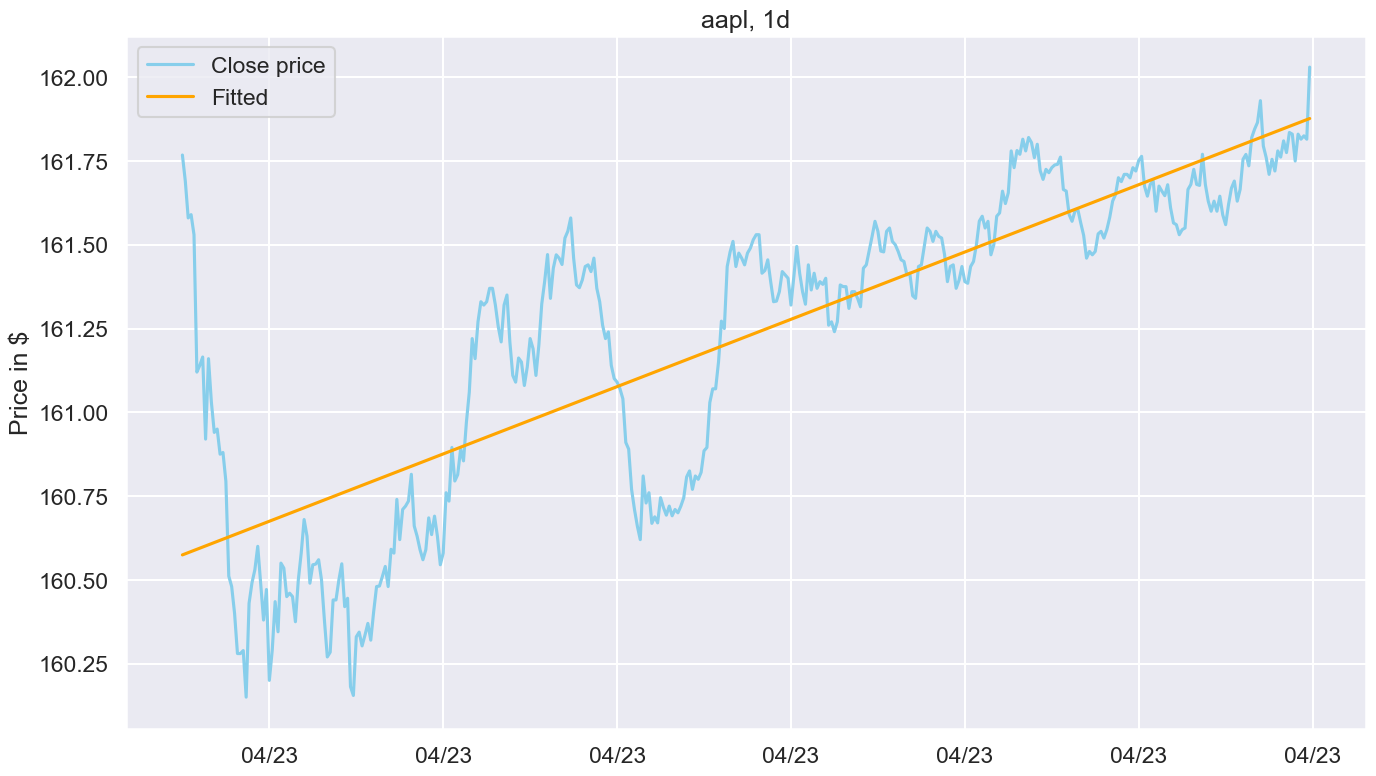

In [141]:
def get_slope_intercept_and_fitted_line_values(ticker, period, interval):
    '''Returns coeff, intercept, and fitted line values.'''

    latest_prices_df = yf.download(
        tickers=ticker,
        period=period,
        interval=interval,
    )

    x = latest_prices_df.index
    y = latest_prices_df.Close

    # Create sequence of integers from 0 to x.size to use in np.polyfit()
    x_seq = np.arange(x.size)

    fit = np.polyfit(x_seq, y, 1)
    coeff = fit[0]
    intercept = fit[1]

    fitted_line = coeff * x_seq + intercept
    latest_prices_df["Fitted"] = fitted_line

    return coeff, intercept, latest_prices_df


# coeff, intercept, latest_prices_df = get_slope_intercept_and_fitted_line_values(
#     "aapl", '1d', '1m')

# fig, ax = plt.subplots(figsize=(16, 9))

# ax.plot(latest_prices_df.index, latest_prices_df.Close,
#         label='Close price', color='skyblue')
# ax.plot(latest_prices_df.index, latest_prices_df.Fitted,
#         label='Fitted', color='orange')

# ax.legend(loc='best')
# ax.set_ylabel('Price in $')
# ax.set_title(f'aapl, 1d')
# ax.xaxis.set_major_formatter(my_year_month_fmt)

# latest_prices_df.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

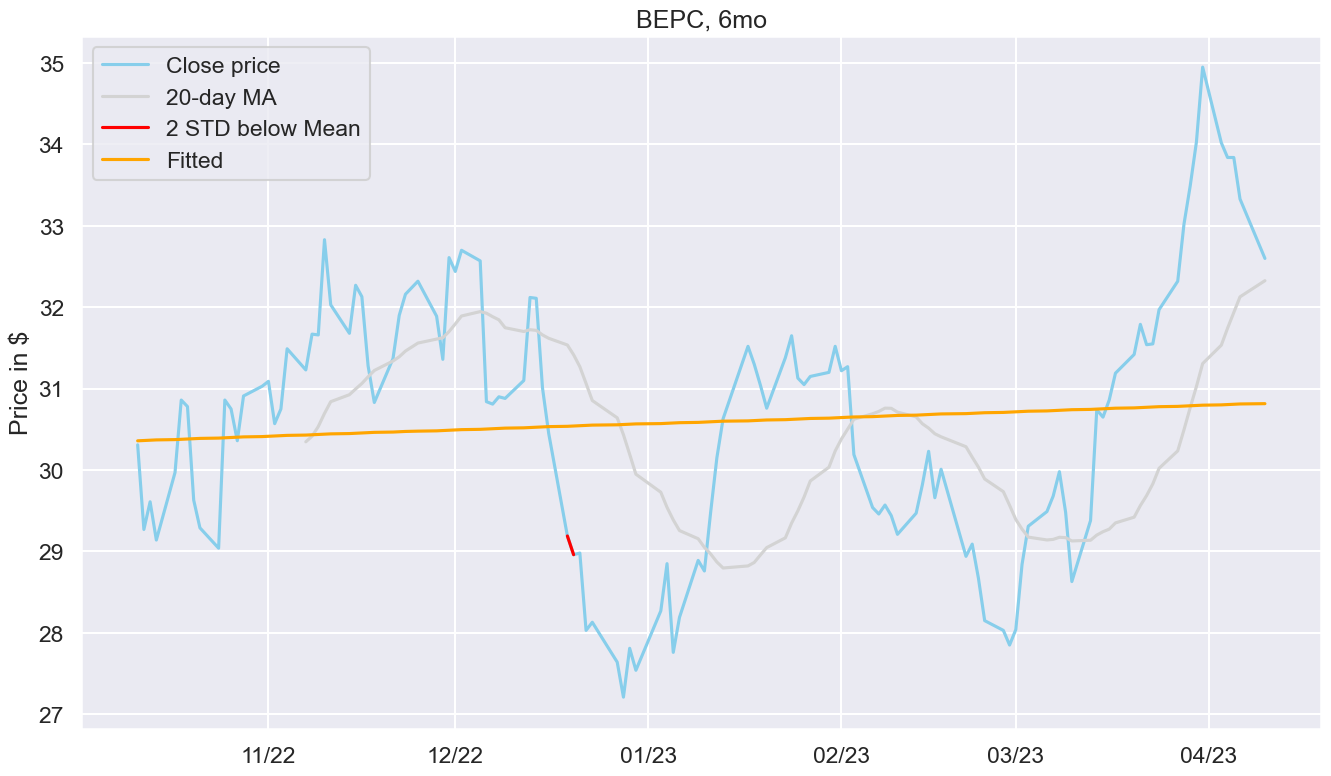

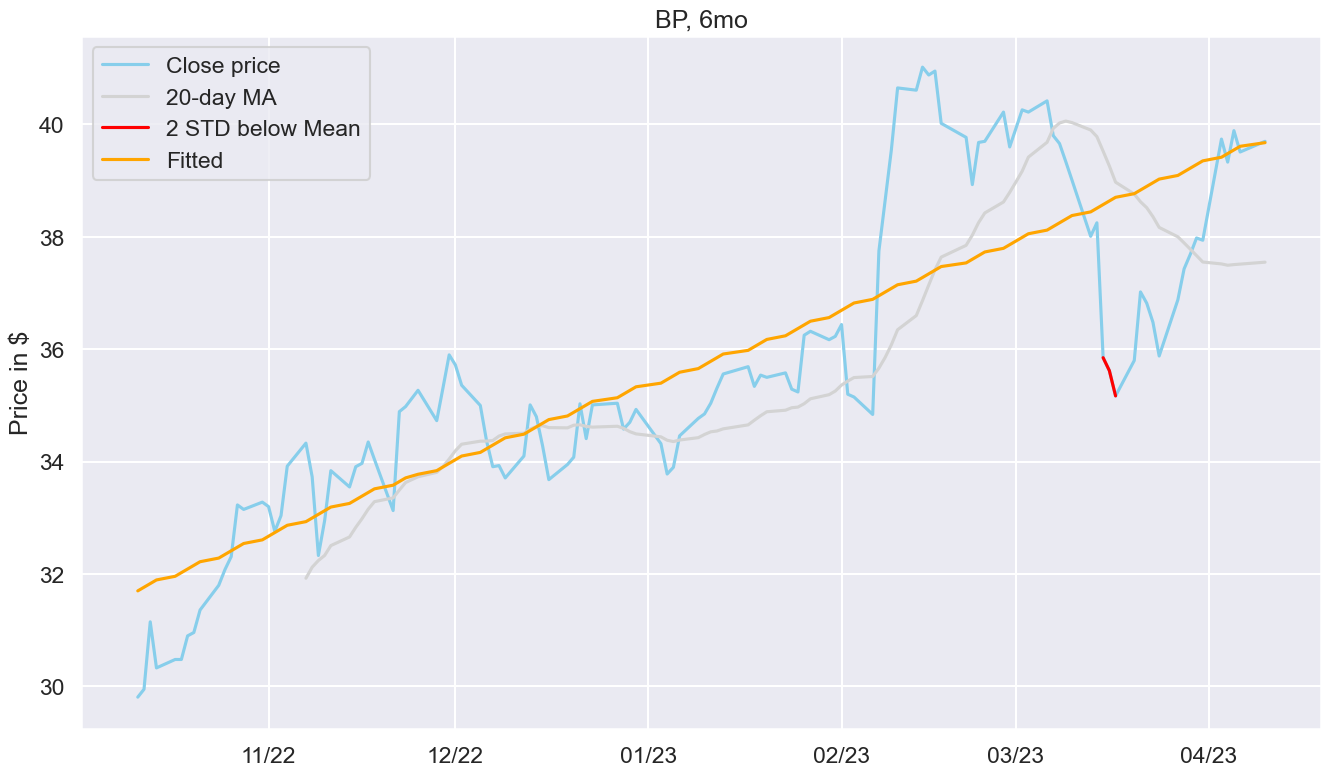

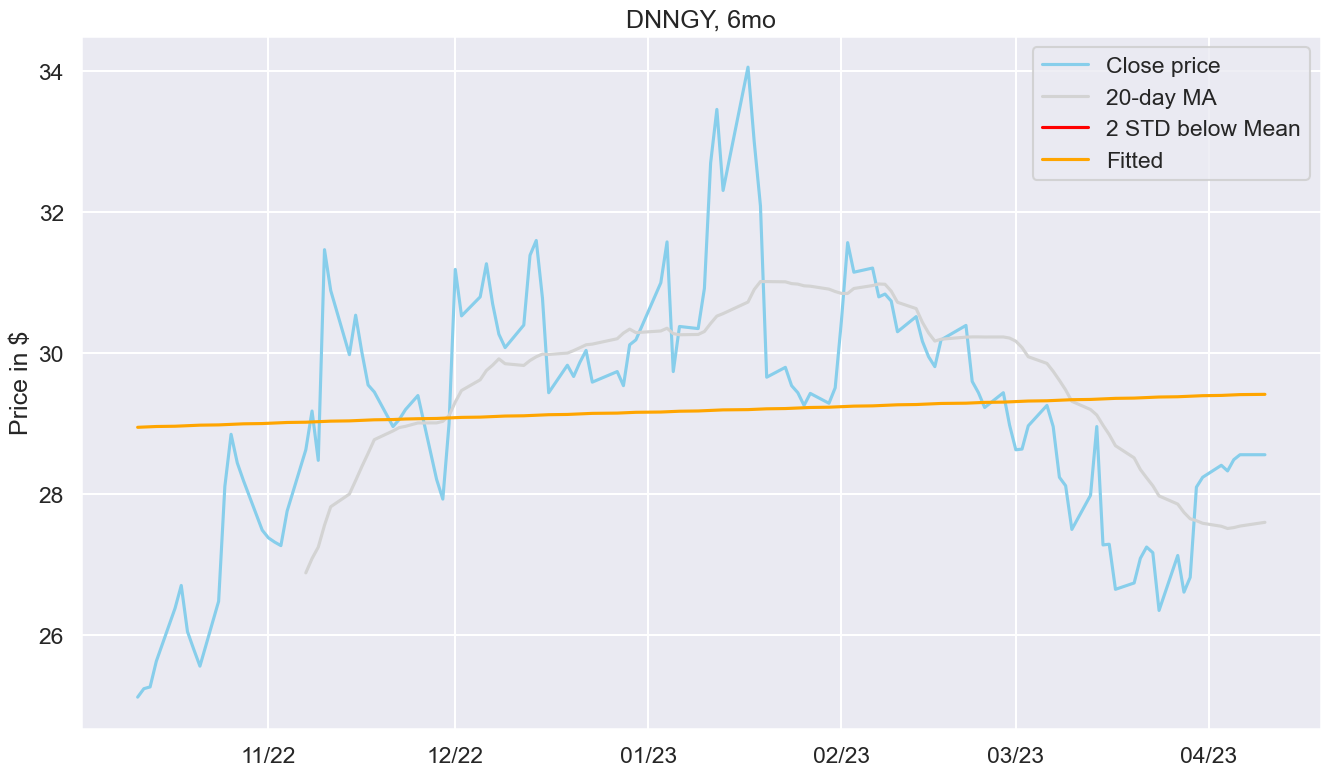

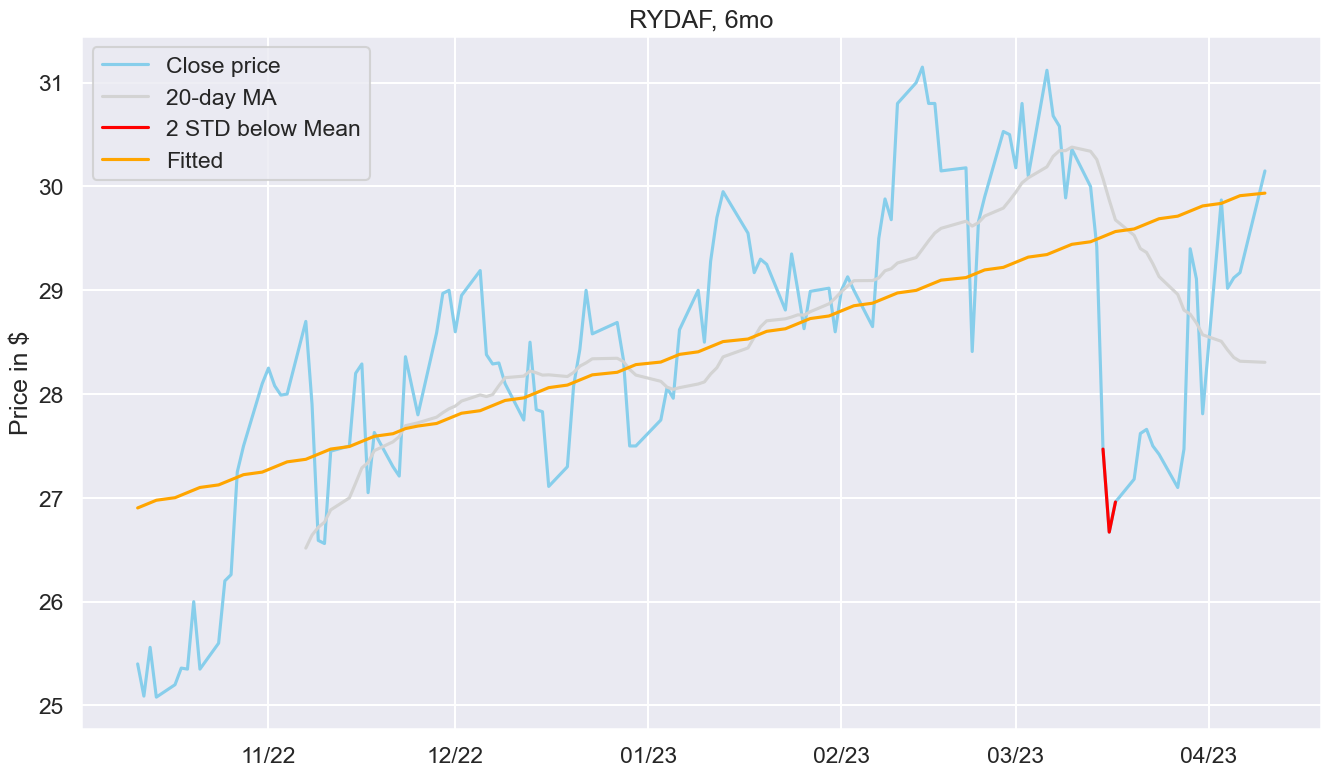

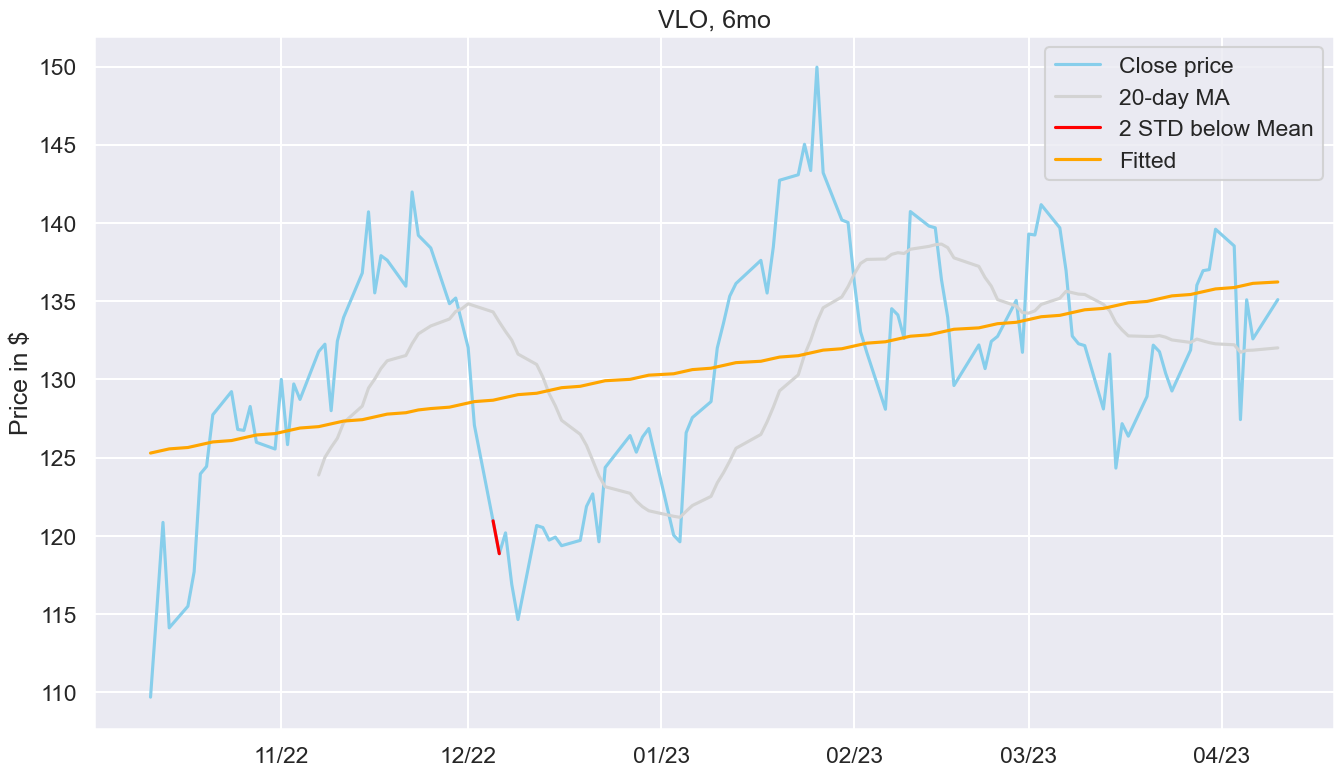

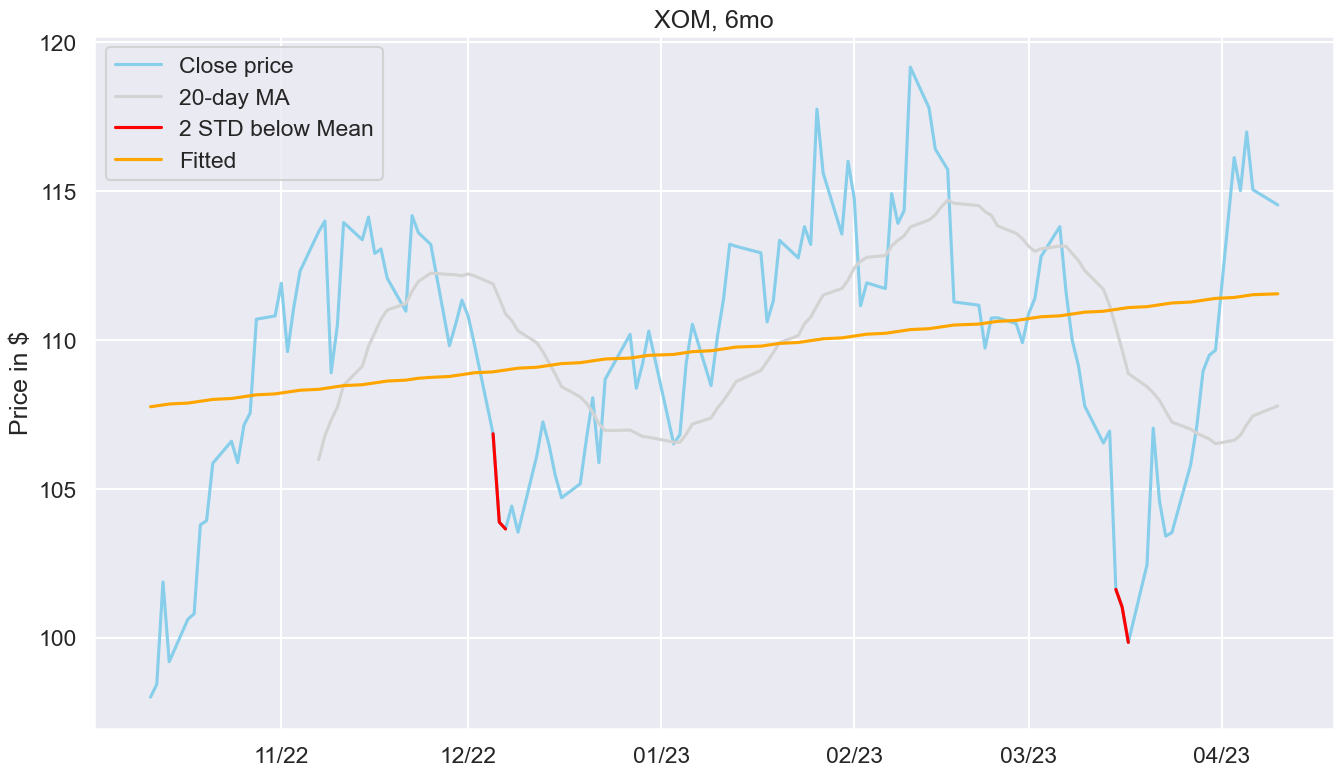

In [143]:
def plot_ticker(ticker, df):
    fig, ax = plt.subplots(figsize=(16,9))

    ax.plot(df.index, df.Close, label='Close price', color='skyblue')
    ax.plot(df.index, df['Close Rolling Mean'], label = f'{ma_and_std_window}-day MA', color='lightgrey')
    ax.plot(df.index, df['2 STD Below Mean (Close)'], label = f'2 STD below Mean', color='red')
    ax.plot(df.index, df.Fitted, label='Fitted', color='orange')

    ax.legend(loc='best')
    ax.set_ylabel('Price in $')
    ax.set_title(f'{ticker}, {period}')
    ax.xaxis.set_major_formatter(my_year_month_fmt)

def visualise_dataframes(tickers):
    for ticker in tickers:
        df = multi_df[ticker]

        x = df.index
        y = df.Close

        # Create sequence of integers from 0 to x.size to use in np.polyfit()
        x_seq = np.arange(x.size)

        # Lease squares polynomial fit
        fit = np.polyfit(x_seq, y, 1)
        coeff = fit[0]
        intercept = fit[1]

        # Rising trend over longer period
        if coeff > 0:

            latest_coeff, latest_intercept, latest_prices_df = get_slope_intercept_and_fitted_line_values(
                ticker, "1d", "1m")

            # Falling trend over last 24 hours
            if latest_coeff < 0:

                # print(f'Slope: {coeff}, Intercept: {intercept}')
                fitted_line = coeff * x_seq + intercept
                df["Fitted"] = fitted_line

                plot_ticker(ticker, df)


visualise_dataframes(tickers)


In [ ]:
now = datetime.now(tz=pytz.timezone('US/Eastern'))
current_hour = now.hour
current_minute = now.minute
current_second = now.second
current_weekday = now.weekday()
now

datetime.datetime(2023, 4, 10, 16, 26, 14, 529530, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>)

In [ ]:
# min = 900 # 15 min
min = 900

def keep_running(multi_df_last_period, tickers, min):
    watchlist = []
    
    while True:
        clear_output(wait=False)
        print("New round")
        multi_df_today = download_data(tickers, '1d', interval)
        
        for ticker in tickers:
            df_last_period = multi_df_last_period[ticker]
            two_std_below_mean = df_last_period.iloc[len(df_last_period)-2]['2 STD Below Mean'].item()
            
            latest_close = multi_df_today[ticker]['Close'].item()
                
            if latest_close < two_std_below_mean and ticker not in watchlist:
                
                watchlist.append({
                    "ticker": ticker,
                    "close": latest_close
                })
                
                df_last_period.to_csv(f"new results/{ticker}.csv")
                
                playsound('sound.mp3')
        
        for item in watchlist:
            # Save this to file so we can work on it in another nb
            print(f"{item['ticker']}: {item['close']}")

        time.sleep(min)

keep_running(multi_df, tickers, min)

New round
[*********************100%***********************]  60 of 60 completed


OSError: Cannot save file into a non-existent directory: 'new results'